In [1]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
from scipy import sparse
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.decomposition import PCA
from sklearn.model_selection import cross_validate, StratifiedKFold, train_test_split
import matplotlib.pyplot as plt
import time
np.random.seed(42)

import warnings
warnings.filterwarnings('ignore')

# Sử dụng Softmax làm đầu vào cho bài toán hồi quy

In [2]:
def softmax_stable(Z):
    """
    Sử dụng softmax_stable để tránh tràn số
    """
    e_Z = np.exp(Z - np.max(Z, axis = 0, keepdims = True))
    A = e_Z / e_Z.sum(axis = 0)
    return A

def convert_labels(y, C):
    """
    Biến vector y thành ma trận one-hot
    """
    Y = sparse.coo_matrix((np.ones_like(y),
        (y, np.arange(len(y)))), shape = (C, len(y))).toarray()
    return Y

def loss_function(X, Y, W):
    """
    Tính hàm mất mát cross-entropy loss
    """
    A = softmax_stable(W.T.dot(X))
    return -np.sum(Y*np.log(A))

def softmax_regression(X, y, W_init, eta, tol = 1e-4, max_count = 50000):
    W = [W_init]
    C = W_init.shape[1]
    Y = convert_labels(y, C)
    it = 0
    N = X.shape[1]
    d = X.shape[0]

    count = 0
    check_w_after = 20
    while count < max_count:
        mix_id = np.random.permutation(N)
        for i in mix_id:
            xi = X[:, i].reshape(d, 1)
            yi = Y[:, i].reshape(C, 1)
            ai = softmax_stable(np.dot(W[-1].T, xi))
            W_new = W[-1] + eta*xi.dot((yi - ai).T)
            count += 1
            # Điều kiện dừng
            if count%check_w_after == 0:
                if np.linalg.norm(W_new - W[-check_w_after]) < tol:
                    return W
            W.append(W_new)
    return W

def pred(W, X, index):
    """
    Đầu vào cho bài toán hồi quy
    """
    A = softmax_stable(W.T.dot(X))
    return A[index]

## Xây dựng mô hình

In [3]:
def test_softmax_regression_output(df, test_size, index, eta=0.05, random_state=14):
    target = "Classification"
    x = df.drop(target, axis = 1).to_numpy()
    y_raw = df[target].to_numpy()

    # Encode nhãn
    LB = LabelEncoder()
    y = LB.fit_transform(y_raw)

    # Split
    x_train, x_test, y_train, y_test = train_test_split(
        x, y, test_size=test_size, random_state=random_state, stratify=y
    )

    # Scale
    sc = StandardScaler()
    x_train_sc = sc.fit_transform(x_train)
    x_test_sc  = sc.transform(x_test)

    # Add bias
    x_train = np.concatenate([np.ones((x_train_sc.shape[0], 1)), x_train_sc], axis=1)
    x_test  = np.concatenate([np.ones((x_test_sc.shape[0], 1)), x_test_sc], axis=1)

    # Train softmax
    d = x_train.shape[1]
    C = len(np.unique(y))
    W_init = np.random.rand(d, C)

    W_hist = softmax_regression(x_train.T, y_train, W_init, eta=eta)
    W = W_hist[-1]

    # Đầu ra hồi quy
    y_pred = pred(W, x_test.T, index).reshape(-1)

    y_test = (y_test == index).astype(float)

    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)

    print(f"Chosen class index = {index} (label = {LB.classes_[index]})")
    print(f"MAE  = {mae:.4f}")
    print(f"RMSE = {rmse:.4f}")
    print(f"R2   = {r2:.4f}")

    # Trực quan hóa tương quan dự đoán – thực tế
    plt.figure()
    plt.scatter(y_test, y_pred)
    plt.xlabel("y_true (0/1)")
    plt.ylabel("y_pred (prob of class k)")
    plt.title(f"Predicted prob vs True (class={LB.classes_[index]})")
    plt.show()


### Thử trên dữ liệu gốc gồm 9 class

In [4]:
import os
BASE_DIR = os.path.dirname(
    os.path.dirname(
        os.path.dirname(
            os.path.abspath('notebook/preprocessing.ipynb'))))

# Sử dụng trên bộ dữ liệu 9 class và 4 class
# Do đầu ra của bộ dữ liệu có một số class quá ít nên ta tiến hành loại bỏ các hàng dữ liệu chứa các class thiểu số đó
df_4_class = pd.read_csv(os.path.join(BASE_DIR, 'data/processed_data_4_classes.csv'))
df_9_class = pd.read_csv(os.path.join(BASE_DIR, 'data/processed_data_9_classes.csv'))

df_pca_9_class = pd.read_csv(os.path.join(BASE_DIR, 'data/X_9_classes_PCA_6dims.csv'))
df_pca_4_class = pd.read_csv(os.path.join(BASE_DIR, 'data/X_4_classes_PCA_6dims.csv'))

#### Kịch bản 1 (Train/Test = 0.8/0.2)

Chosen class index = 0 (label = C2S1)
MAE  = 0.0464
RMSE = 0.1370
R2   = 0.8928


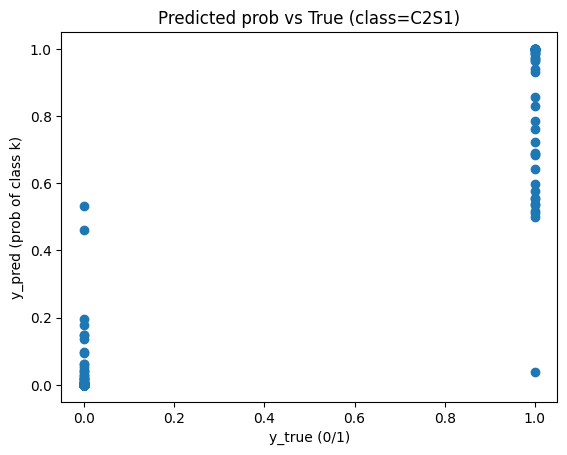

In [5]:
test_softmax_regression_output(df_9_class, 0.2, 0)

#### Kịch bản 2 (Train/Test = 0.7/0.3)

Chosen class index = 0 (label = C2S1)
MAE  = 0.0488
RMSE = 0.1532
R2   = 0.8660


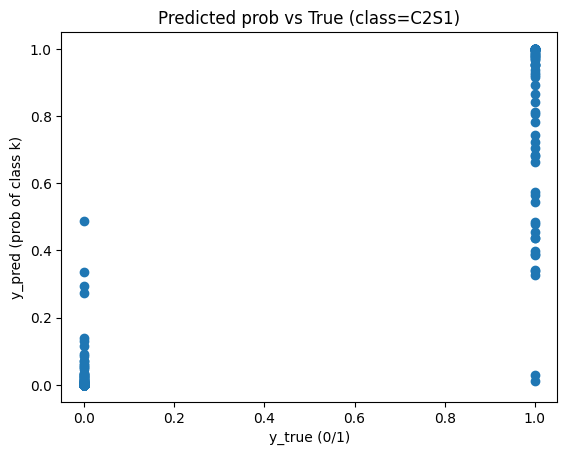

In [6]:
test_softmax_regression_output(df_9_class, 0.3, 0)

#### Kịch bản 3 (Train/Test = 0.6/0.4)

Chosen class index = 0 (label = C2S1)
MAE  = 0.0387
RMSE = 0.1268
R2   = 0.9076


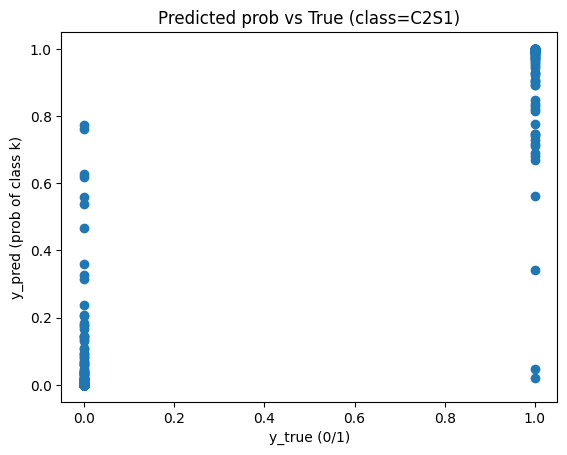

In [7]:
test_softmax_regression_output(df_9_class, 0.4, 0)

### Thử trên bộ dữ liệu 4 class

Chosen class index = 0 (label = C2S1)
MAE  = 0.0440
RMSE = 0.1303
R2   = 0.9052


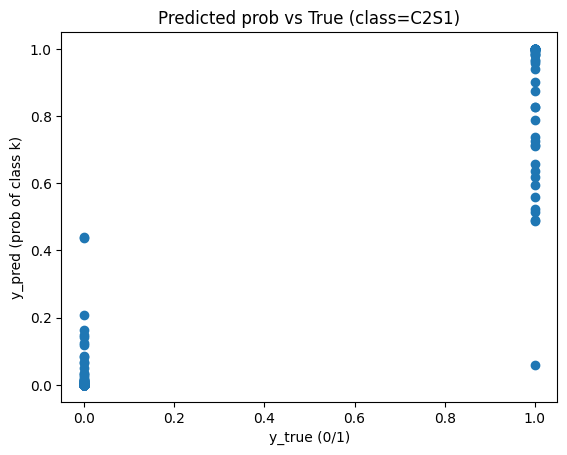

In [8]:
test_softmax_regression_output(df_4_class, 0.2, 0)

Chosen class index = 0 (label = C2S1)
MAE  = 0.0390
RMSE = 0.1264
R2   = 0.9107


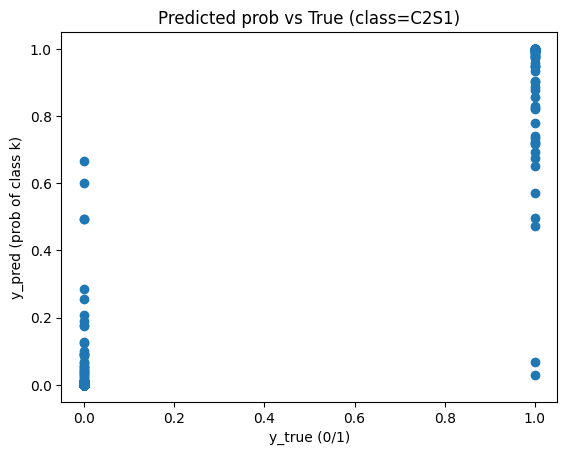

In [9]:
test_softmax_regression_output(df_4_class, 0.3, 0)

Chosen class index = 0 (label = C2S1)
MAE  = 0.0374
RMSE = 0.1238
R2   = 0.9139


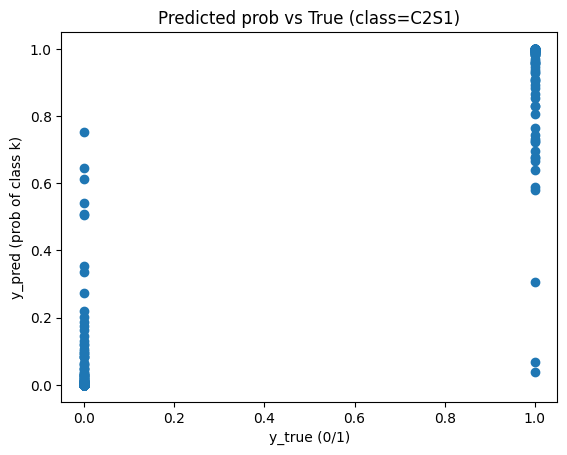

In [10]:
test_softmax_regression_output(df_4_class, 0.4, 0)

## Giảm chiều dữ liệu bằng pca

Chosen class index = 0 (label = C2S1)
MAE  = 0.0547
RMSE = 0.1455
R2   = 0.8791


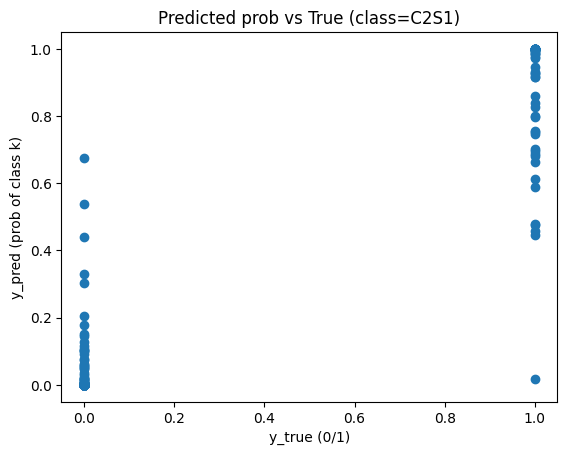

In [11]:
test_softmax_regression_output(df_pca_9_class, 0.2, 0)

Chosen class index = 0 (label = C2S1)
MAE  = 0.0546
RMSE = 0.1442
R2   = 0.8813


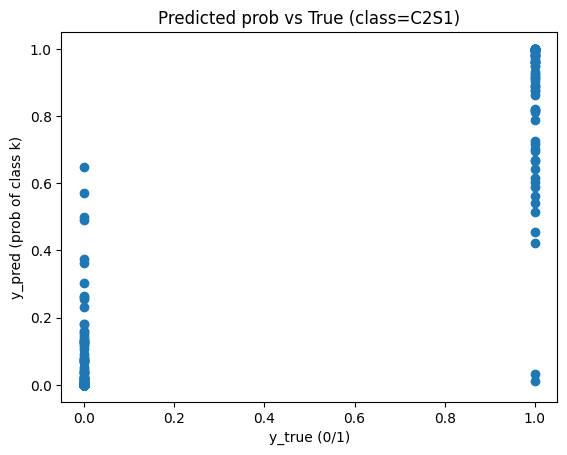

In [12]:
test_softmax_regression_output(df_pca_9_class, 0.3, 0)

Chosen class index = 0 (label = C2S1)
MAE  = 0.0566
RMSE = 0.1512
R2   = 0.8688


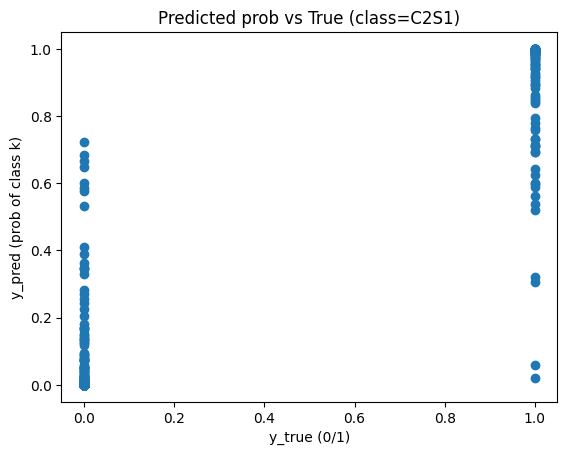

In [13]:
test_softmax_regression_output(df_pca_9_class, 0.4, 0)

Chosen class index = 0 (label = C2S1)
MAE  = 0.0503
RMSE = 0.1341
R2   = 0.8995


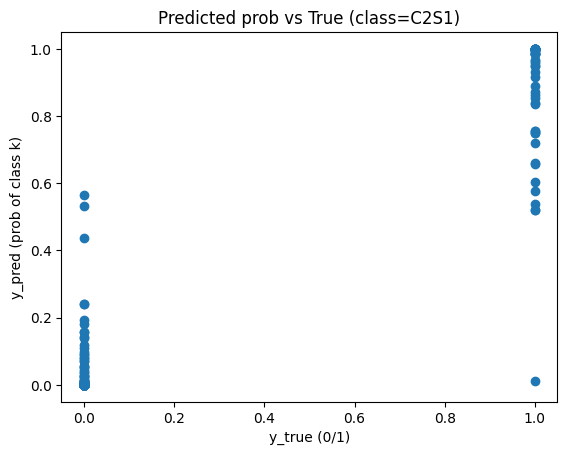

In [14]:
test_softmax_regression_output(df_pca_4_class, 0.2, 0)

Chosen class index = 0 (label = C2S1)
MAE  = 0.0560
RMSE = 0.1496
R2   = 0.8750


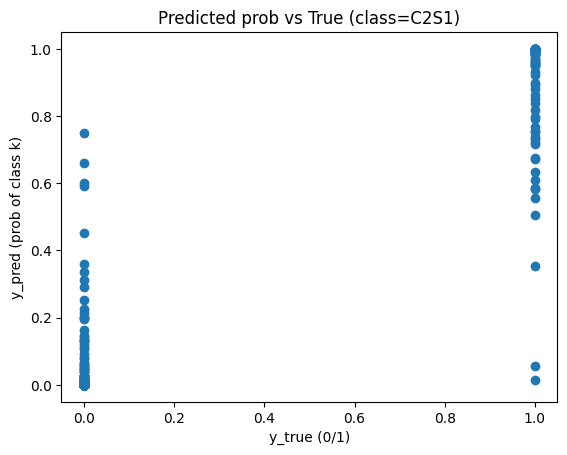

In [15]:
test_softmax_regression_output(df_pca_4_class, 0.3, 0)

Chosen class index = 0 (label = C2S1)
MAE  = 0.0535
RMSE = 0.1456
R2   = 0.8809


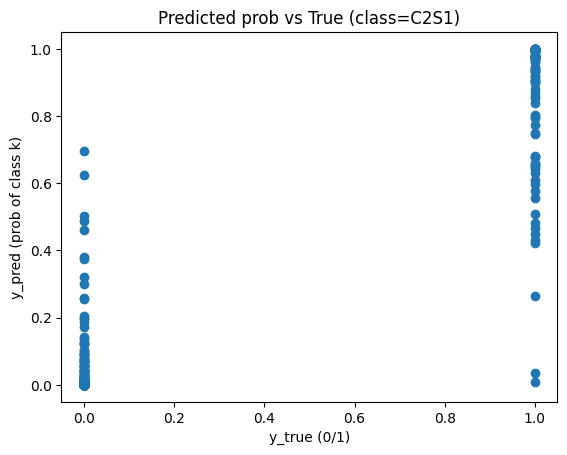

In [16]:
test_softmax_regression_output(df_pca_4_class, 0.4, 0)